# EDA

In [1]:
# Imports
import os, sys
import cv2
import numpy as np
import pandas as pd
import imagehash
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

# Add src to path
sys.path.append("..")

from src.utils.paths import get_project_path

In [2]:
image_path = []

# Get image paths
for root, dirs, files in os.walk(os.path.join(get_project_path(), "data")):
    for file in files:
        if file.endswith(".jpg"):
            image_path.append(os.path.join(root, file))

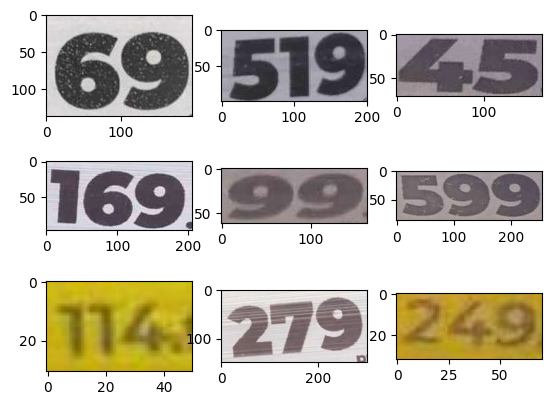

In [3]:
# Show images
plt.figure()
plt.subplots_adjust()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.imread(image_path[i]))

# Analyze dataframe with labels

### Train dataset

In [4]:
# Load data
train_df = pd.read_csv(os.path.join(get_project_path(), "data", "train.csv"))
train_df.head()

,img_name,text
0,511192609_2.jpg,109.0
1,508986495_2.jpg,64.0
2,511284449_2.jpg,101.0
3,509225880_2.jpg,229.0
4,509069568_2.jpg,39.0


In [5]:
train_df.describe()

,text
count,4952.000000
mean,348.738086
std,525.778649
min,2.000000
25%,89.000000
50%,168.000000
75%,399.000000
max,9999.000000


In [6]:
train_df.isnull().sum()

img_name    0
text        0
dtype: int64

Text(0, 0.5, 'Count')

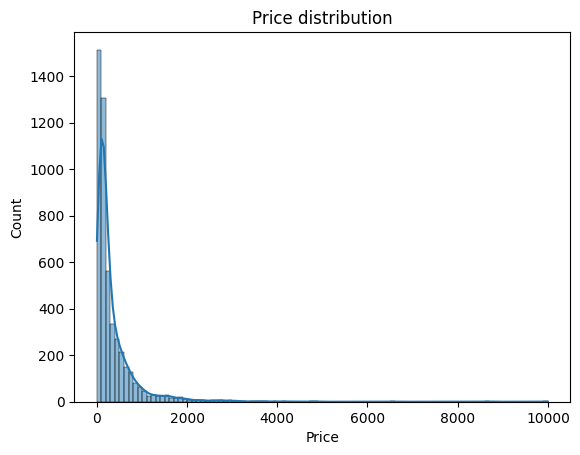

In [7]:
# Show distribution
plt.figure()
sns.histplot(train_df["text"], bins=100, kde=True)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Count")

### Validation dataset

In [8]:
val_df = pd.read_csv(os.path.join(get_project_path(), "data", "val.csv"))
val_df.head()

,img_name,text
0,508763287_2.jpg,105.0
1,508811724_2.jpg,33.0
2,508757581_2.jpg,23.0
3,509323355_2.jpg,79.0
4,483319419_2.jpg,95.0


In [9]:
val_df.describe()

,text
count,1000.000000
mean,339.175000
std,576.207559
min,5.000000
25%,85.000000
50%,159.000000
75%,399.000000
max,8999.000000


In [10]:
train_df.isnull().sum()

img_name    0
text        0
dtype: int64

Text(0, 0.5, 'Count')

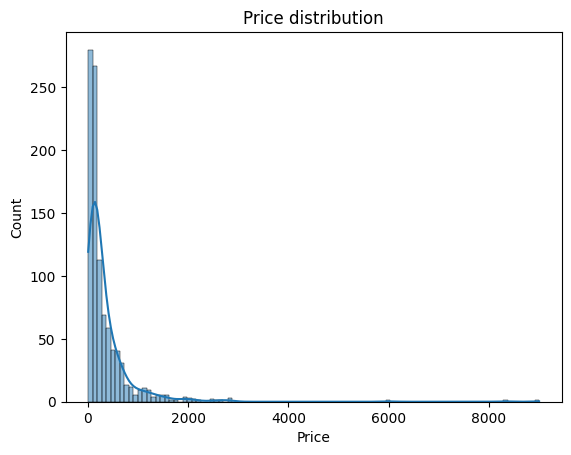

In [11]:
# Show distribution
plt.figure()
sns.histplot(val_df["text"], bins=100, kde=True)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Count")

### Test dataset

In [12]:
test_df = pd.read_csv(os.path.join(get_project_path(), "data", "test.csv"))
test_df.head()

,img_name
0,511228291_2.jpg
1,510883758_2.jpg
2,509390607_2.jpg
3,508764417_2.jpg
4,510880074_2.jpg


In [13]:
test_df.describe()

,img_name
count,238
unique,238
top,511228291_2.jpg
freq,1


In [14]:
test_df.isnull().sum()

img_name    0
dtype: int64

# Find duplicates

In [15]:
def find_duplicate_images(directory, hash_func=imagehash.phash, hash_size=16, threshold=0):
    """
    Searches for duplicate images in the specified directory.
    
    :param directory: Path to the directory containing images.
    :param hash_func: Hash computation function (default is phash).
    :param hash_size: Hash size (larger values increase accuracy but slow down computation).
    :param threshold: Maximum allowed Hamming distance between hashes to consider images as duplicates 
                      (0 means only exact hash matches are considered).
    :return: A dictionary where each key is a computed hash and the value is a list of files with that hash.
             If threshold is greater than 0, duplicates are grouped considering the allowed difference.
    """
    # Dictionary for storing hashes and file paths
    image_hashes = defaultdict(list)
    
    # We go through all the files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            file_path = os.path.join(directory, filename)
            try:
                image = Image.open(file_path)
                # Calculating the perceptual hash
                hash_val = hash_func(image, hash_size=hash_size)
                image_hashes[str(hash_val)].append(file_path)
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")
    
    # If threshold is 0, then only images with identical hashes will be considered duplicates.
    if threshold == 0:
        duplicates = {h: paths for h, paths in image_hashes.items() if len(paths) > 1}
    else:
        # If threshold > 0, you need to compare all the hashes with each other.
        duplicates = {}
        processed = set()
        hash_keys = list(image_hashes.keys())
        for i in range(len(hash_keys)):
            current_hash = imagehash.hex_to_hash(hash_keys[i])
            group = image_hashes[hash_keys[i]].copy()
            processed.add(hash_keys[i])
            for j in range(i + 1, len(hash_keys)):
                compare_hash = imagehash.hex_to_hash(hash_keys[j])
                # Calculating the Hamming distance between the hashes
                if current_hash - compare_hash <= threshold:
                    group.extend(image_hashes[hash_keys[j]])
                    processed.add(hash_keys[j])
            if len(group) > 1:
                duplicates[str(current_hash)] = group

    return duplicates

In [16]:
duplicates = find_duplicate_images(os.path.join(get_project_path(), "data", "imgs"))
duplicates

{}

# Conclusion

*The EDA showed:*
- Train dataset contains 4952 images
- Validation dataset contains 1000 images
- Test dataset contains 238 images
- The distribution of labels is inclined towards small numeric values
- In dataset no duplicate images
- PyTesseract will not work with dataset
- CNN on 10000 classes not effective